## **A personal study of the Viola-Jones face detection, an academic approach and implementation and comparison with ready to use openCV's algorithm**

Paper in [this link](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf)

A very useful book [here](https://www.yumpu.com/en/document/read/18418164/implementing-the-viola-jones-face-detection-algorithm)

In [181]:
%matplotlib inline

import os
import random
import tarfile
from typing import *
from sklearn.metrics import *
import requests
import shutil
import hashlib
import glob
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import *
import seaborn as sns

#images
from IPython.display import FileLink, FileLinks, Latex
FileLink('./images/images/features.png')


/home/abdel_dakri/work/Vision_pattern_rec/Viola_Davis_detector/images/images/features.png

The original image


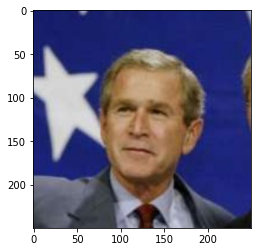

The resized image


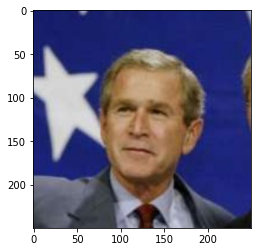

The grey scale image


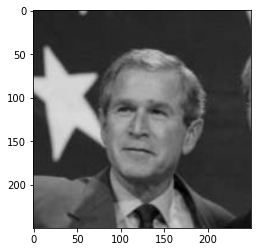

<class 'numpy.ndarray'>


In [2]:
%matplotlib inline

def print_(str):
  print("=======================================================")
  print(str)
    
    
def show(image: np.ndarray):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

#Prepping the data

G_BUSH_IMG = "./images/data/George_W_Bush_0001.jpg"

image = cv.imread(G_BUSH_IMG)
print_("The original image")
show(image)


#In accordance with the original paper we use an image of 382x288
cv.resize(image, (100,100))
print_("The resized image")
show(image)


#Greyscale image
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
print_("The grey scale image")
show(gray)


#converting images to numpy is not necessary
print(type(image))
#print(image)


**Manual implementation of the Haar feature detection**




We implement the window feature to transform the image into an integral form, this form allows us to easily compute the sum of all pixels inside a rectangle

(Foreshadowing) these will be the Haar features ! 


<img src="./images/images/features.png" width=400 height=100 />


Each feature results in a single value Which is calculated by subtracting the sum of the white rectangle(s) from the sum of the black rectangle(s).

Viola-Jones have empirically found that a detector with a base resolution of 24*24 pixels gives satisfactory results. When allowing for all possible sizes and positions of the features in the figure above a total of approximately 160.000 different features can then be constructed. Thus, the amount of possible features vastly outnumbers the 576 pixels contained in the detector at base resolution.

These features may seem overly simple to perform such an advanced task as face detection, but what the features lack in complexity they most certainly have in computational efficiency. One could understand the features as the computer’s way of perceiving an input image. The hope being that some features will yield large values when on top of a face. Of course Operations could also be carried out directly on the raw pixels, but the variation due to different pose and individual characteristics would be expected to hamper this approach. The goal is now to smartly construct a mesh of features capable of detecting faces and this is the topic of the next section.





(250, 250, 3)
The original image


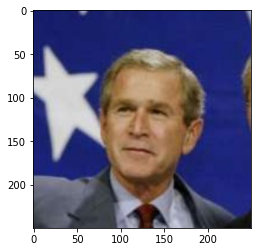

The resized image


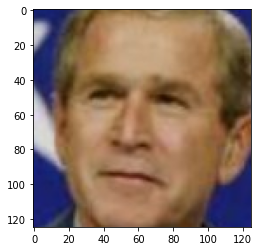

(125, 125, 3)


In [3]:
# The evaluation of each feature could be done by explicitly instantiating a kernel 
# of the size of the window (here, $24 \times 24$) and folding it with the image under the window. 
# This, however, leads to $24 \times 24 = 576$ multiplications and $24 \times 24 - 1 = 575$ additions 
# per kernel and window, resulting in an exessively high number of operations for an entire image.
# We can do better using an Integral Image transformation.
# To save computation we downgrade

print(np.shape(image))
print_("The original image")
show(image)

sample_image = image[65:190, 65:190, :]

print_("The resized image")
show(sample_image)
print(np.shape(sample_image))


**Integral images**

The greyscale image


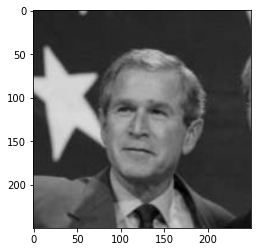

(250, 250)
[[ 39  36  34 ... 158 170 180]
 [ 39  36  34 ... 156 166 177]
 [ 39  36  34 ... 150 164 175]
 ...
 [ 49  50  52 ...  16  14  14]
 [ 49  49  50 ...  15  14  14]
 [ 48  48  49 ...  15  14  14]]
(251, 251)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.46421912e-06 1.43542675e-05 ... 2.14184811e-03
  2.17438445e-03 2.20883469e-03]
 [0.00000000e+00 1.49284382e-05 2.87085351e-05 ... 4.26206912e-03
  4.32637623e-03 4.39470255e-03]
 ...
 [0.00000000e+00 3.05688481e-03 6.14554041e-03 ... 9.85895688e-01
  9.88977645e-01 9.92236064e-01]
 [0.00000000e+00 3.06626294e-03 6.16429665e-03 ... 9.89770383e-01
  9.92855020e-01 9.96116118e-01]
 [0.00000000e+00 3.07544967e-03 6.18267011e-03 ... 9.93648906e-01
  9.96736222e-01 1.00000000e+00]]


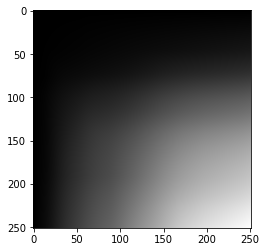

In [4]:
print_("The greyscale image")
show(gray)

def to_integral(img: np.ndarray) -> np.ndarray:
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    #return integral
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]


print(np.shape(gray)) 

print(gray)

integral = to_integral(gray)
integral = integral / integral.max()

print(np.shape(integral))
print(integral)

img_float32 = np.float32(integral)
plt.imshow(cv.cvtColor(img_float32, cv.COLOR_BGR2RGB))
plt.show()

# Training sets

In [5]:
dataset_path = 'dataset'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)
    
def download_file(url: str, path: str):
    print('Downloading file ...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    print('Download completed.')
    
def md5(path: str, chunk_size: int=65536) -> str:
    hash_md5 = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def untar(file_path: str, dest_path: str):
    print('Extracting file.')
    with tarfile.open(file_path, 'r:gz') as f:
        f.extractall(dest_path)
    print('Extraction completed.')

The Datset we will use will be [A Century of Portraits: A Visual Historical Record of American High School Yearbooks](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html)

```shell
Shiry Ginosar, Kate Rakelly, Sarah Sachs, Brian Yin, Crystal Lee, Alexei A. Efros A Century of Portraits: A Visual Historical Record of American High School Yearbooks, in IEEE Transactions on Computational Imaging, Vol. 3, No. 3, September 2017. PDF, BibTeX
```

In [6]:
FACES_URL = 'https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1'
FACES_MD5 = 'ab853c17ca6630c191457ff1fb16c1a4'

FACES_ARCHIVE = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz')
FACES_DIR = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned')

if not os.path.exists(FACES_ARCHIVE) or md5(FACES_ARCHIVE) != FACES_MD5:
    download_file(FACES_URL, FACES_ARCHIVE)

In [7]:
if not os.path.exists(FACES_DIR):
    untar(FACES_ARCHIVE, dataset_path)

face_image_files = glob.glob(os.path.join(FACES_DIR, '**', '*.png'), recursive=True)
print(len(face_image_files))

37921


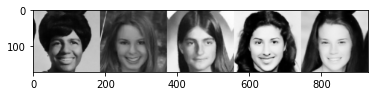

In [8]:
#Let's show some faces
def open_face(path: str, resize: bool=True) -> np.ndarray:    
    img = cv.imread(path)
    cv.resize(np.uint8(img), (240, 240))
    cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def merge_images(files: Iterable[str], open_fun: Callable, resize: bool=False) -> np.ndarray:
    images = [open_fun(f, resize) for f in files]
    sizes = [img.size for img in images]
    list_imgs = []
    
    for img, size in zip(images, sizes):
        list_imgs.append(img)
    result = np.hstack(list_imgs)
    show(result)
    return result
                            
                            
random.seed(200)
random_face_files = random.sample(face_image_files, 5)
_ = merge_images(random_face_files, open_face)



The training dataset is now good for faces, we will need to also be able to detect "not faces". We use the Stanford Backgrounds Dataset for scene understanding.

In [9]:
backgrounds_url = 'http://dags.stanford.edu/data/iccv09Data.tar.gz'
backgrounds_md5 = 'f469cf0ab459d94990edcf756694f4d5'

backgrounds_archive = os.path.join(dataset_path, 'iccv09Data.tar.gz')
backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')

if not os.path.exists(backgrounds_archive):
    download_file(backgrounds_url, backgrounds_archive)


if not os.path.exists(backgrounds_dir):
    untar(backgrounds_archive, dataset_path)

background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
len(background_image_files)

715

In [10]:
def open_scene(path: str, resize: bool=True) -> np.ndarray:    
    img = cv.imread(path)
    cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img[0:100,0:100]

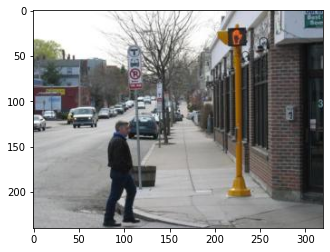

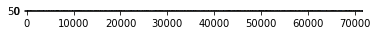

In [11]:
from datetime import datetime
random.seed(datetime.now())

random_face_files = random.sample(background_image_files, 5)
image = cv.imread(random_face_files[0])
show(image)

_ = merge_images(background_image_files, open_scene)

## VERY IMPORTANT NOTE

We will use iconic images ($15 \times 15$) since we are using a notebook and limited computing power. We will hopefully not be forced to do this in the scripted pre-trained NN (Python+Keras) so time performance will duely not be evaluated as a performance metric. 

In [12]:
WINDOW_SIZE = 15

## Let's do some classic ML

We have to define features. 

<sub>It has been a long time since I used Python classes, so let's get into it.</sub> 

In [13]:
# Testing the features

print(" The test array (modlelling a 1 channel image) \n ")
sample_image =  np.array([
    [5, 2, 3, 4, 1], 
    [1, 5, 4, 2, 3],
    [2, 2, 1, 3, 4],
    [3, 5, 6, 4, 5],
    [4, 1, 3, 2, 6]], dtype=int
    )

sample_integral = to_integral(sample_image)

print(" The integral form : \n")
sample_integral

 The test array (modlelling a 1 channel image) 
 
 The integral form : 



array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

In [14]:
#helper class Box that allows to determine the integral of an image region by means of the integral image.

class Box:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.coords_x = [x, x + width, x,          x + width]
        self.coords_y = [y, y,         y + height, y + height]
        self.coeffs   = [1, -1,        -1,         1]
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))


# Class for features (Who knows, we only implement haar features but other features might exist)

class Feature:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    
    def __call__(self, integral_image: np.ndarray) -> float:
        try:
            return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))
        except IndexError as e:
            raise IndexError(str(e) + ' in ' + str(self))
    
    def __repr__(self):
        return f'{self.__class__.__name__}(x={self.x}, y={self.y}, width={self.width}, height={self.height})'
    
    


In [15]:
class Feature2h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + height, y + height,
                         y,      y,          y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,
                         -1,     1,          1,         -1]

class Feature2v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hh = height // 2        
        self.coords_x = [x,      x + width,  x,          x + width,
                         x,      x + width,  x,          x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [-1,     1,          1,         -1,
                         1,     -1,         -1,          1]
    
expected = - Box(0, 1, 4, 2)(sample_integral) + Box(0, 3, 4, 2)(sample_integral)
actual = Feature2v(0, 1, 4, 4)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

class Feature3h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        tw = width // 3
        self.coords_x = [x,        x + tw,    x,          x + tw,
                         x + tw,   x + 2*tw,  x + tw,     x + 2*tw,
                         x + 2*tw, x + width, x + 2*tw,   x + width]
        self.coords_y = [y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height]
        self.coeffs   = [-1,       1,         1,         -1,
                          1,      -1,        -1,          1,
                         -1,       1,         1,         -1]

expected = - Box(0, 0, 1, 2)(sample_integral) + Box(1, 0, 1, 2)(sample_integral) - Box(2, 0, 1, 2)(sample_integral)
actual = Feature3h(0, 0, 3, 2)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

class Feature3v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        th = height // 3
        self.coords_x = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.coords_y = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.coeffs   = [-1,        1,         1,         -1,
                          1,       -1,        -1,          1,
                         -1,        1,         1,         -1]

expected = - Box(0, 0, 2, 1)(sample_integral) + Box(0, 1, 2, 1)(sample_integral) - Box(0, 2, 2, 1)(sample_integral)
actual = Feature3v(0, 0, 2, 3)(sample_integral)
assert expected == actual, f'{expected} == {actual}'

class Feature4(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        hh = height // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,     # upper row
                         x + hw, x + width,  x + hw,     x + width,
                         x,      x + hw,     x,          x + hw,     # lower row
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,     # upper row
                         y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height, # lower row
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,          # upper row
                         -1,     1,          1,         -1,
                         -1,     1,          1,         -1,          # lower row
                          1,    -1,         -1,          1]

expected = Box(0, 0, 2, 2)(sample_integral) - Box(2, 0, 2, 2)(sample_integral) \
         - Box(0, 2, 2, 2)(sample_integral) + Box(2, 2, 2, 2)(sample_integral)
actual = Feature4(0, 0, 4, 4)(sample_integral)
assert expected == actual, f'{expected} == {actual}'


#This implementation was heavily inspired by Markus Mayer's implementation of the Viola Davies detector. 



In [16]:

# Image navigation with wavelets
Size = NamedTuple('Size', [('height', int), ('width', int)])
Location = NamedTuple('Location', [('top', int), ('left', int)])


def possible_position(size: int, window_size: int = WINDOW_SIZE) -> Iterable[int]:
    return range(0, window_size - size + 1)

def possible_locations(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Location]:
    base_height = base_shape.height
    base_width = base_shape.width
    return (Location(top=y, left=x)
            for x in possible_position(base_height, window_size) 
            for y in possible_position(base_width, window_size))

def possible_shapes(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Size]:
    base_height = base_shape.height
    base_width = base_shape.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))






In [17]:
print("Testing possible sliding positions \n")
list(possible_locations(Size(height=2, width=2), 20))

Testing possible sliding positions 



[Location(top=0, left=0),
 Location(top=1, left=0),
 Location(top=2, left=0),
 Location(top=3, left=0),
 Location(top=4, left=0),
 Location(top=5, left=0),
 Location(top=6, left=0),
 Location(top=7, left=0),
 Location(top=8, left=0),
 Location(top=9, left=0),
 Location(top=10, left=0),
 Location(top=11, left=0),
 Location(top=12, left=0),
 Location(top=13, left=0),
 Location(top=14, left=0),
 Location(top=15, left=0),
 Location(top=16, left=0),
 Location(top=17, left=0),
 Location(top=18, left=0),
 Location(top=0, left=1),
 Location(top=1, left=1),
 Location(top=2, left=1),
 Location(top=3, left=1),
 Location(top=4, left=1),
 Location(top=5, left=1),
 Location(top=6, left=1),
 Location(top=7, left=1),
 Location(top=8, left=1),
 Location(top=9, left=1),
 Location(top=10, left=1),
 Location(top=11, left=1),
 Location(top=12, left=1),
 Location(top=13, left=1),
 Location(top=14, left=1),
 Location(top=15, left=1),
 Location(top=16, left=1),
 Location(top=17, left=1),
 Location(top=18, lef

In [18]:
print("Testing possible sliding shapes \n")
list(possible_shapes(Size(height=1, width=2), 5))

Testing possible sliding shapes 



[Size(height=1, width=2),
 Size(height=2, width=2),
 Size(height=3, width=2),
 Size(height=4, width=2),
 Size(height=5, width=2),
 Size(height=1, width=4),
 Size(height=2, width=4),
 Size(height=3, width=4),
 Size(height=4, width=4),
 Size(height=5, width=4)]

In [19]:
# So how much sliding are we doing

feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature4  = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

features = feature2h + feature2v + feature3h + feature3v + feature4

print(f'Number of feature2h features: {len(feature2h)}')
print(f'Number of feature2v features: {len(feature2v)}')
print(f'Number of feature3h features: {len(feature3h)}')
print(f'Number of feature3v features: {len(feature3v)}')
print(f'Number of feature4 features:  {len(feature4)}')
print(f'Total number of features:     {len(features)}')
print("** That's a lot of sliding!")

Number of feature2h features: 6720
Number of feature2v features: 6720
Number of feature3h features: 4200
Number of feature3v features: 4200
Number of feature4 features:  3136
Total number of features:     24976
** That's a lot of sliding!


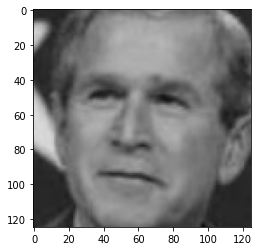

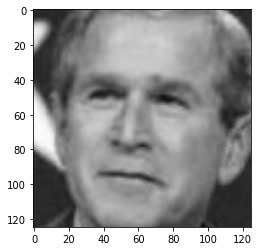

array([[45, 44, 44, ..., 46, 44, 44],
       [43, 42, 42, ..., 45, 45, 44],
       [44, 43, 40, ..., 44, 44, 44],
       ...,
       [45, 44, 45, ..., 43, 43, 44],
       [44, 42, 43, ..., 43, 43, 44],
       [40, 39, 44, ..., 43, 43, 43]], dtype=uint8)

In [20]:
# Back to the George Bush picture, let's see if we can optimise it (as a piece of our dataset)

#np.set_printoptions(threshold=sys.maxsize)
image = cv.imread(G_BUSH_IMG)
sample_image = image[65:190, 65:190, :]

# Normalize the images
def normalize(im: np.ndarray, mean: float = 0., std: float = 1.) -> np.ndarray:
    return cv.normalize(im, None, alpha=0., beta=255., norm_type=cv.NORM_MINMAX, dtype=None)

def grey_normalize(im: np.ndarray, debug: bool = False) -> np.ndarray:
    grey_image = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    if(debug):
        show(grey_image)

    sample_mean = grey_image.mean()
    sample_std = grey_image.std()

    #print(f'Sample mean: {sample_mean}, standard deviation: {sample_std}')

    image_normalized = normalize(grey_image)
    if(debug):
        show(image_normalized)
    return image_normalized

grey_normalize(sample_image, debug = True) 





(15, 15, 3)


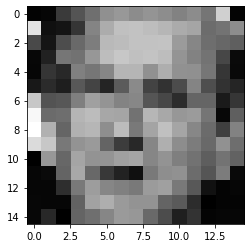

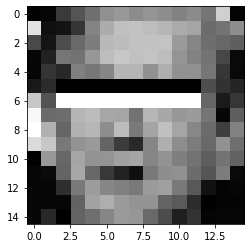

(16, 16, 5)
()


In [21]:
# A study case of the G.W.Bush with the features

# We use Lanzos interpolation to reconstruct a viable window (https://en.wikipedia.org/wiki/Lanczos_resampling)

RESIZED_SAMPLE = cv.resize(sample_image, (WINDOW_SIZE, WINDOW_SIZE), interpolation = cv.INTER_LANCZOS4)

print(RESIZED_SAMPLE.shape)

GREY_SAMPLE = grey_normalize(RESIZED_SAMPLE, debug = False) 

show(GREY_SAMPLE)



left, width = 2, 10
top, height = 5, 2

SAMPLE_MASKED = GREY_SAMPLE.copy()
SAMPLE_MASKED[top:top+height//2, left:left+width] = 0
SAMPLE_MASKED[top+height//2:top+height, left:left+width] = 255
show(SAMPLE_MASKED)

# Applying the feature

f = Feature2v(x=5, y=5, width=3, height=2)

SAMPLE_INTEGRAL = to_integral(RESIZED_SAMPLE)

SAMPLE_F = f(SAMPLE_MASKED) 

print(SAMPLE_INTEGRAL.shape)

print(SAMPLE_F.shape)


**Setting up data loaders with KERAS**

We have to set up the data to be sampled, transformed ...

Since we got up to using Keras, let's set up our data loaders using Keras.

Fetching the data
Found 37921 files belonging to 2 classes.
Using 30337 files for training.


2021-12-28 16:09:38.700918: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-28 16:09:38.881759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-28 16:09:39.605548: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-28 16:09:39.605628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP): /proc/driver/nvidia/version does not exist
2021-12-28 16:09:39.697887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-28 16:09:39.713459

Found 37921 files belonging to 2 classes.
Using 7584 files for validation.


2021-12-28 16:09:41.230027: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-28 16:09:41.262475: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2096074999 Hz
2021-12-28 16:09:41.455158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:41.480757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:41.515234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:41.549424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:41.576012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:41.599286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:41.619710: W te

2021-12-28 16:09:43.214487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.230485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.277269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.318292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.331532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.344770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.367976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.409885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:43.434658: W tensorflow/core/lib/png/png_io.cc:88] PNG 

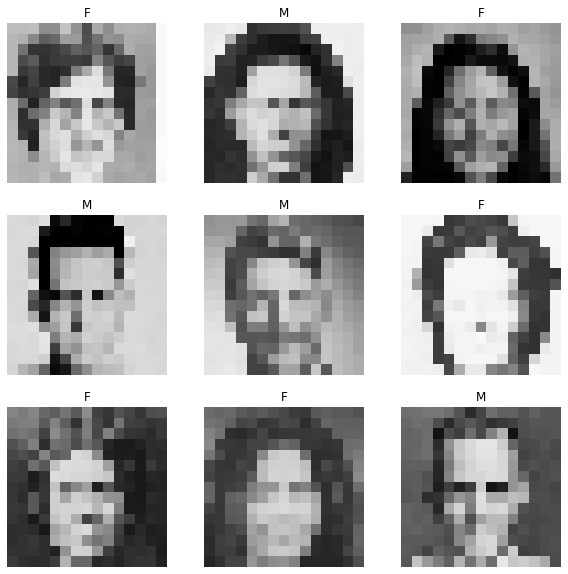

In [22]:
F_IMG_DIR  = os.path.join(FACES_DIR, "F")
M_IMG_DIR  = os.path.join(FACES_DIR, "M")
BATCH_SIZE = 13

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 



import warnings
with warnings.catch_warnings(record=True):
    #Hiding the warnings does not work
    print_("Fetching the data")
    
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        FACES_DIR, image_size=(WINDOW_SIZE, WINDOW_SIZE), batch_size=64)
    """
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      FACES_DIR,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(WINDOW_SIZE, WINDOW_SIZE),
      batch_size=BATCH_SIZE)
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      FACES_DIR,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(WINDOW_SIZE, WINDOW_SIZE),
      batch_size=BATCH_SIZE)



    class_names = train_ds.class_names

    plt.figure(figsize=(10, 10))
    
    #cycle through a batch
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

**A simple case illustration**
Each of our features generates a scalar value for a given input image. This value will be used in order to find a threshold for which we will classify the images and decide whether an image is containing a face or whether it doesn't. We select the threshold in a way such that it minimizes false-positive and false-negative classification errors.

Let's look at Bush's face again.


A BATCH FROM THE TRAINING DATA


2021-12-28 16:09:44.747445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.749263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.751042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.752836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.754686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.756949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.758870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.760871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:44.762474: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2021-12-28 16:09:45.284782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.304562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.324052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.366417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.375604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.398879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.417125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.442839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 16:09:45.462446: W tensorflow/core/lib/png/png_io.cc:88] PNG 

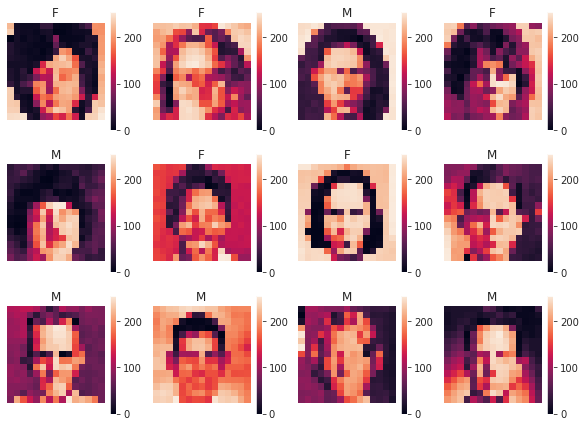

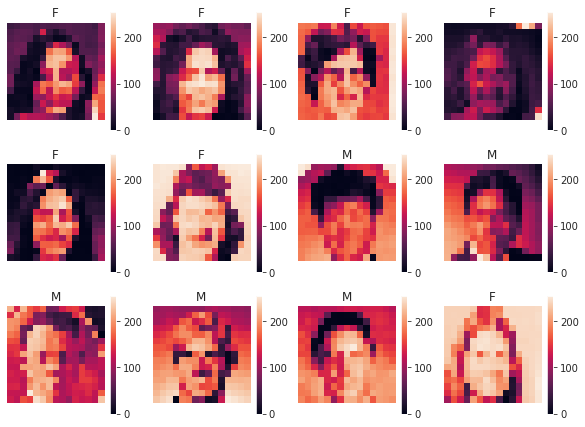

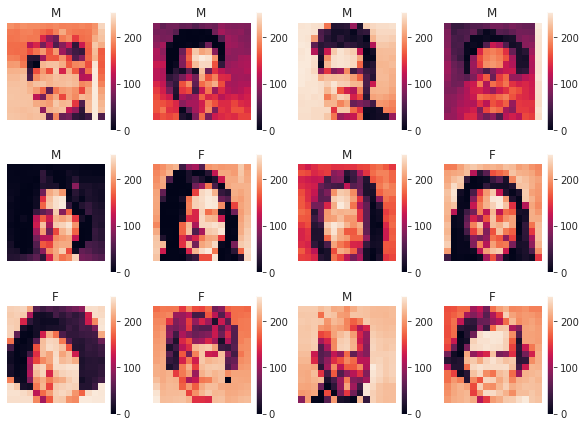

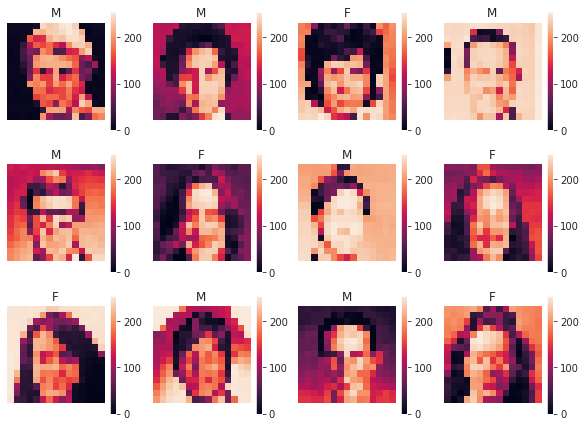

In [23]:
#Seeborn parameters
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.color_palette("flare", as_cmap=True)

f = Feature2v(x=left, y=top, width=width, height=height)

random.seed(0)
np.random.seed(0)

# print(type(train_ds))
# <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>

# the elements
# <tf.Tensor: shape=(12, 15, 15, 3), dtype=float32, numpy.ndarray>    


class_names = train_ds.class_names

def batch_normalize(n : int = 1):
    print("A BATCH FROM THE TRAINING DATA")
    images_np = []
    labels_np = []
    for images,labels in train_ds.take(n):
        plt.figure(figsize=(10, 10))
        j = 0
        batch_np = []
        batch_labels_np = []
        while(j < BATCH_SIZE - 1):
            ax = plt.subplot(4, 4, j + 1)
            plt.imshow(grey_normalize(images[j].numpy().astype("uint8"), debug = False))
            plt.colorbar()
            plt.title(class_names[labels[j]])
            plt.axis("off")
            j += 1
            batch_np.append([grey_normalize(images[j].numpy().astype("uint8"), debug = False)])
            batch_labels_np.append(class_names[labels[j]])
        images_np.append(batch_np)
        labels_np.append(batch_labels_np)
    return images_np, labels_np


# lists of BATCH_SIZE -1 elements in 2D arrays of n batchs
images , labels = batch_normalize(4)


<class 'list'>
[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]


/home/abdel_dakri/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/abdel_dakri/.local/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/abdel_dakri/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/ab

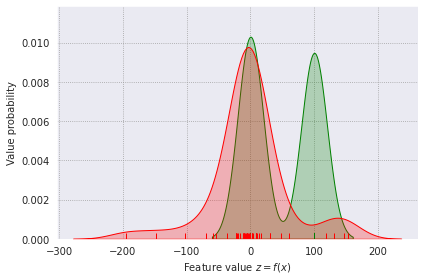

In [57]:
zs = []
ws = []
scores = []


def non_face():
    img = np.random.normal(0, 255, (1, WINDOW_SIZE,WINDOW_SIZE))
    return abs(img)


#print(non_face())


f = Feature2v(x=5, y=5, width=3, height=2)
# Making the intergal images
for i in images:
    for j in i:
        l = np.shape(j)
        #print(l)
        zs.append(f(to_integral(j)[1]))
        w = non_face()
        ws.append(f(to_integral(w)[1]))
print(type(zs))


def threshold_results(integrals : np.ndarray, T : float) -> np.ndarray:
      return [ 0 if e < T else 1 for e in integrals ]


mean_f = np.asanyarray(zs).mean()
scores_f = [ 0 if e < mean_f else 1 for e in zs ]
print(scores_f)

mean_nf = np.asanyarray(ws).mean()
scores_nf = [ 0 if e < mean_nf else 1 for e in ws ]
print(scores_nf)

scores = scores_f + scores_nf



scores_n = np.asanyarray(scores) * 100.

a = sns.distplot(scores_n, rug=True, hist=False, color='g', kde_kws={'shade': True});
sns.distplot(zs, rug=True, hist=False, color='r', kde_kws={'shade': True}, ax = a);

plt.xlabel('Feature value $z = f(x)$')
plt.ylabel('Value probability')
plt.tight_layout()

I model the non-faces with randoms of uniform noise. It's not entirely right and certainly while we have a dataset of non-faces images. The things done below should also be done to test the feature probabilities with the non-faces image.

**Computing the average recall and precision**

klearn.metrics.average_precision_score(y_true, y_score, *, average='macro', pos_label=1, sample_weight=None)  [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)

    Compute average precision (AP) from prediction scores.

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:
where and are the precision and recall at the nth threshold [1]. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

Note: this implementation is restricted to the binary classification task or multilabel classification task.

Read more in the User Guide in the link above.

In [71]:
def debug(inn):
    print("DEBUG")
    print("\n")
    print(inn)

[0.05641026 0.05128205 0.78461538 0.60512821 0.01538462 0.07179487
 0.0974359  0.10769231 0.04102564 0.04102564 0.11282051 0.08205128
 0.18974359 1.         0.3025641  0.05641026 0.01025641 0.31282051
 0.11794872 0.03076923 0.24615385 0.15897436 0.02051282 0.67179487
 0.04102564 0.11282051 0.01025641 0.         0.05641026 0.35897436
 0.27692308 0.52820513 0.74871795 0.15897436 0.05128205 0.01538462
 0.02051282 0.02564103 0.03589744 0.02564103 0.03076923 0.75897436
 0.05128205 0.08717949 0.04102564 0.04102564 0.00512821 0.04102564
 0.20939899 0.22698785 0.35449561 0.06397554 0.0189521  0.91971065
 0.01830999 0.39910277 0.4289197  0.32316652 0.65307327 0.03997095
 0.18929558 0.14814902 0.02334251 0.2717716  0.42776455 0.17861037
 0.54789417 0.41380513 0.41509552 0.13404498 0.51777343 0.89960426
 0.34469434 0.80385626 0.20604271 0.63089673 0.48254062 0.27672175
 0.14259058 0.80159067 0.07973672 0.11455615 0.50254226 0.41891216
 0.13745486 0.52088472 1.         0.06175712 0.64399583 0.2345

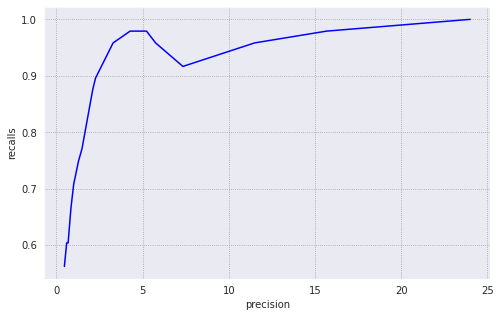

In [104]:
# All the images are faces !
zs = np.asarray(abs(zs / max(zs)))
ws = np.asarray(abs(ws / max(ws)))

alls = np.concatenate( (zs , ws))

print(alls)

truth = np.concatenate( (np.ones(zs.shape) , np.zeros(ws.shape)) )

print(ws.shape)
print(truth)

scores = np.concatenate( (scores_f , scores_nf))

thresholds = [i/20 for i in range(2,20)]
debug(thresholds)

"""
debug(scores_f)
debug(scores_nf)
print(scores)
"""

recall = []
precision = []

for i in thresholds:
    p_scores = threshold_results(alls, i)
    print("**")
    print(p_scores)
    print("****")
    print(np.sum(p_scores == truth))
    print("********")
    print(( np.count_nonzero(p_scores)))
    print("****************")
    
    recall.append(np.sum(p_scores == truth) / np.count_nonzero(p_scores))
    precision.append(np.sum( (p_scores == truth) / np.count_nonzero(truth) ))
    
debug(precision)
debug(recall)
    

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='b')
plt.xlabel("precision")
plt.ylabel("recalls")
plt.show()

# add precision as SVM


It is now clear that the choice of threshhold of each weak-classifier varies a lot, especially from feature to feature. Choosing all the features is not only very costly computationally but also produces a very biased result. This is the job of **Adaptive boosting**.

## Adaptive Boosting

A BATCH FROM THE TRAINING DATA


2021-12-28 17:38:07.029761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.031639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.032539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.033583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.035583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.036367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.037107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.037862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:38:07.038594: W tensorflow/core/lib/png/png_io.cc:88] PNG 

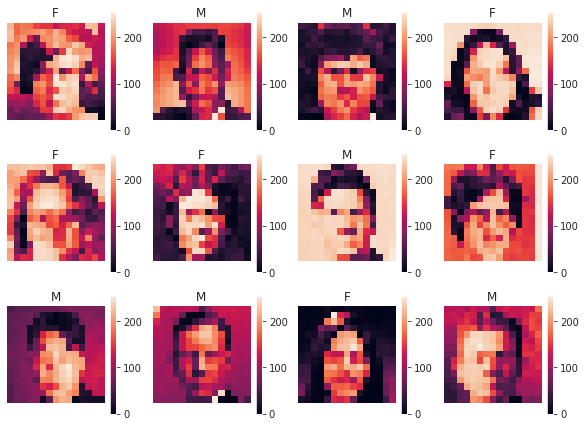

In [149]:
random.seed(18151210)
np.random.seed(18151210)
xs, labels = batch_normalize(1)

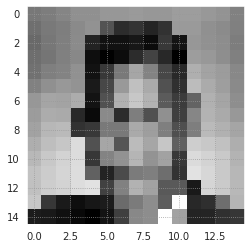

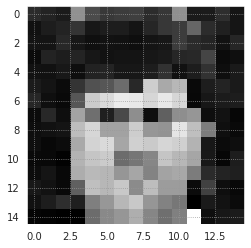

(12, 15, 15)


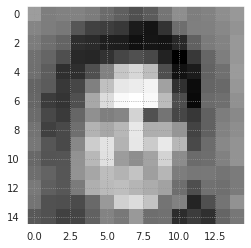

In [173]:
image1 = xs[0][0]
image2 = xs[0][1]

image1 = np.reshape(image1, (WINDOW_SIZE,WINDOW_SIZE) )
image2 = np.reshape(image2, (WINDOW_SIZE,WINDOW_SIZE) )

plt.imshow(image1 , cmap = "gray")
plt.show()
plt.imshow(image2 , cmap = "gray")
plt.show()

images_test = []
integral_test = np.array([to_integral(x) for x in xs[0]])

for i in xs[0]:
    images_test.append(np.reshape(i, (WINDOW_SIZE,WINDOW_SIZE) ))
  
print(np.shape(images_test))
mean_image = np.mean(images_test , axis=0)
# smoothing
mean_image = cv.resize(mean_image, (WINDOW_SIZE, WINDOW_SIZE), interpolation = cv.INTER_LANCZOS4)
plt.imshow(mean_image , cmap = "gray")
plt.show()

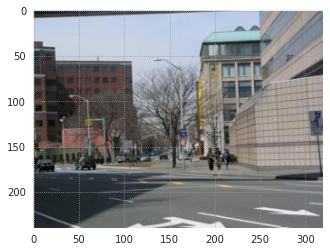

(240, 320, 3)
A BATCH FROM THE BG DATA


/tmp/ipykernel_5561/709425257.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


[['BG', 'BG', 'BG', 'BG', 'BG', 'BG', 'BG', 'BG', 'BG', 'BG', 'BG', 'BG']]


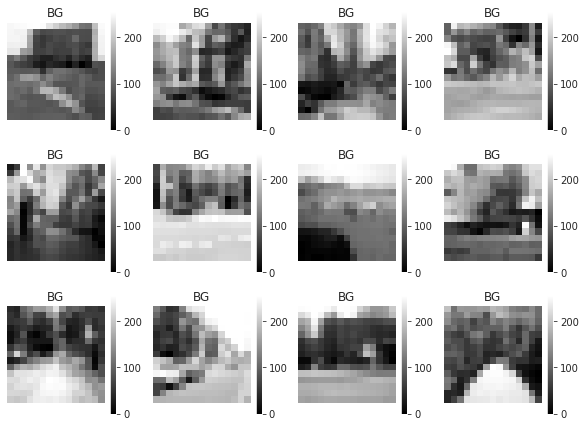

In [175]:
# the backgrounds prp
def batch_normalise_bg(n : int = 1, show: bool = False):
    print("A BATCH FROM THE BG DATA")
    images_np = []
    labels_np = []
    for iterator in range(n):
        j = 0
        batch_np = []
        batch_labels_np = []
        random_face_files = random.sample(background_image_files, BATCH_SIZE)
        plt.figure(figsize=(10, 10))
        while(j < BATCH_SIZE - 1):
            tmp = cv.imread(random_face_files[j])
            tmp = cv.resize(tmp, (WINDOW_SIZE, WINDOW_SIZE), interpolation = cv.INTER_AREA)
            if(show):
                ax = plt.subplot(4, 4, j + 1)
                plt.imshow(grey_normalize(tmp, debug = False), cmap = "gray")
                plt.colorbar()
                plt.title("BG")
                plt.axis("off")
            j += 1
            batch_np.append([grey_normalize(tmp, debug = False)])
            batch_labels_np.append("BG")


        images_np.append(batch_np)
        labels_np.append(batch_labels_np)
    return images_np, labels_np


random_face_files = random.sample(background_image_files, 5)
image = cv.imread(random_face_files[1])
show(image)
print(image.shape)

bg_images, labels_bg = batch_normalise_bg(show = True)
print(labels_bg)

AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique used as an Ensemble Method in Machine Learning. It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights assigned to incorrectly classified instances. Boosting is used to reduce bias as well as variance for supervised learning. It works on the principle of learners growing sequentially. Except for the first, each subsequent learner is grown from previously grown learners. In simple words, weak learners are converted into strong ones. The AdaBoost algorithm works on the same principle as boosting with a slight difference. Let’s discuss this difference in detail.

Let's define the basic componenets of our classifier

In [146]:
ThresholdPolarity = NamedTuple('ThresholdPolarity', [('threshold', float), ('polarity', float)])

ClassifierResult = NamedTuple('ClassifierResult', [('threshold', float), ('polarity', int), 
                                                   ('classification_error', float),
                                                   ('classifier', Callable[[np.ndarray], float])])

WeakClassifier = NamedTuple('WeakClassifier', [('threshold', float), ('polarity', int), 
                                               ('alpha', float), 
                                               ('classifier', Callable[[np.ndarray], float])])

A BATCH FROM THE BG DATA


/tmp/ipykernel_5561/709425257.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


A BATCH FROM THE TRAINING DATA


2021-12-28 17:55:58.743625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.745346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.746974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.748730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.750584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.752289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.753928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.755957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:58.757765: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2021-12-28 17:55:59.697823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.699020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.700321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.701666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.702905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.704101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.705138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.706077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2021-12-28 17:55:59.707032: W tensorflow/core/lib/png/png_io.cc:88] PNG 

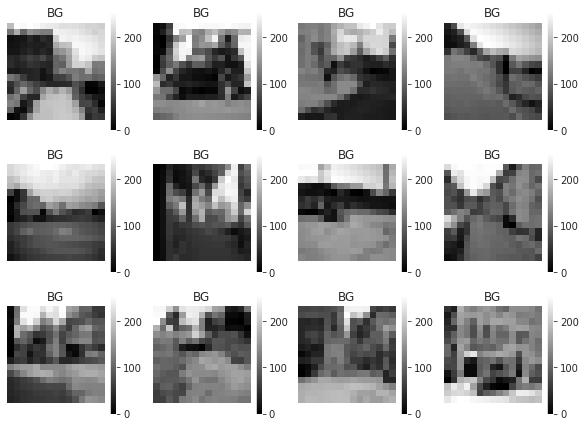

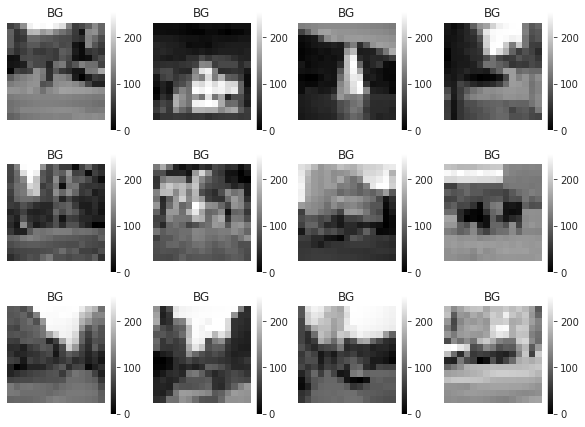

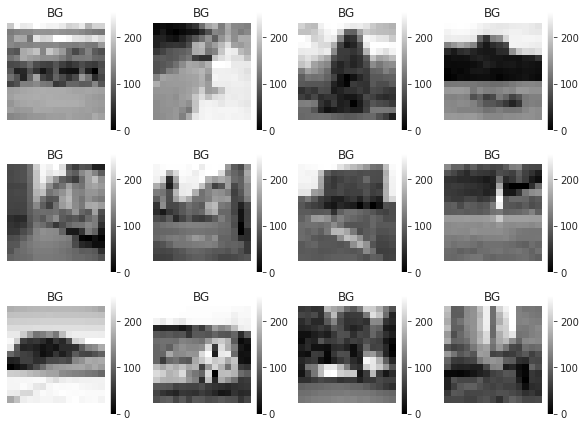

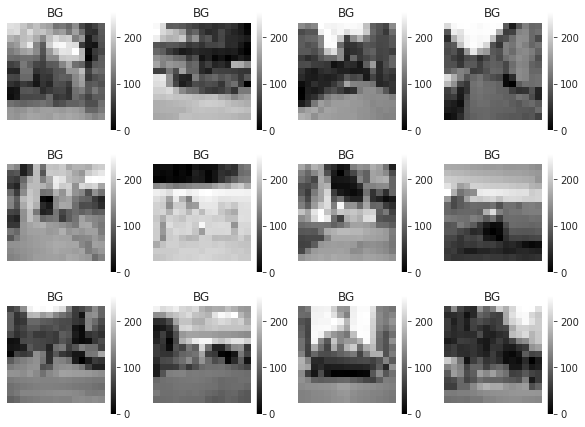

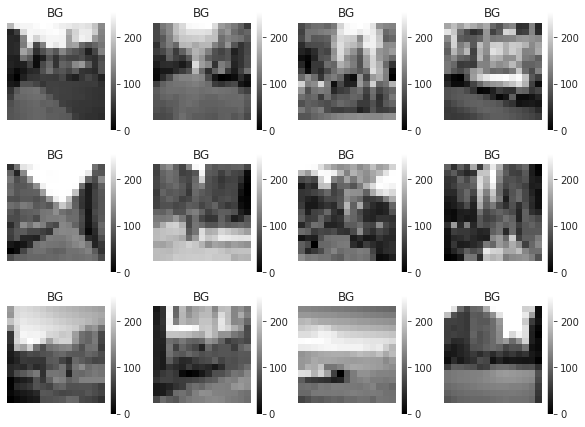

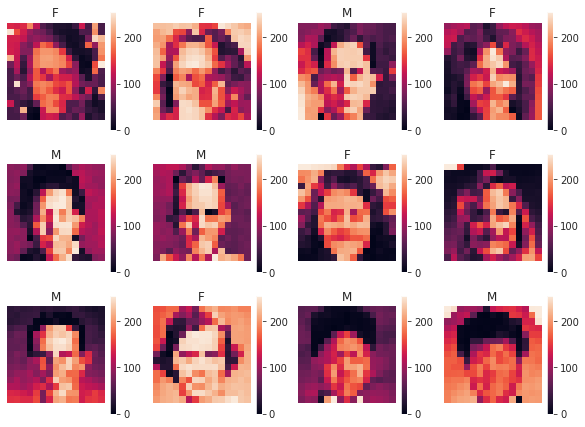

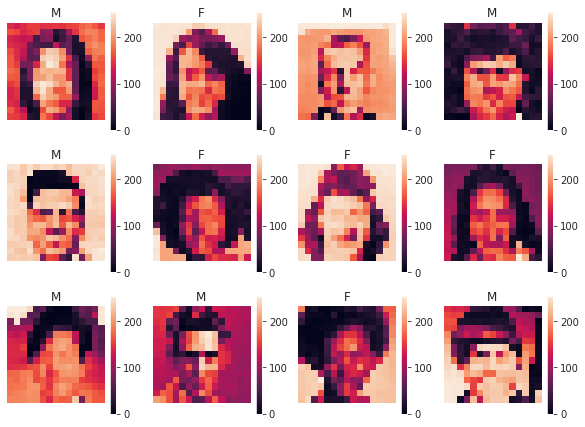

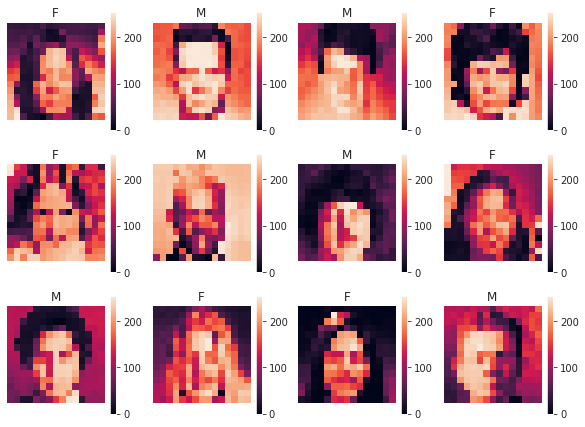

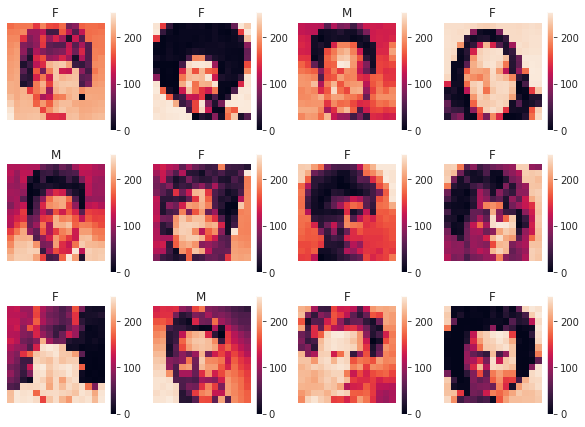

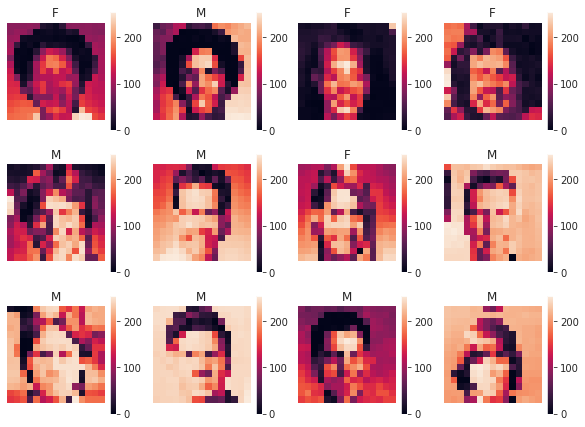

In [177]:
# we have two datasets we will load now
NUM_BATCHES = 5
bg_images, labels_bg = batch_normalise_bg(NUM_BATCHES, show = True)
f_images, labels_f = batch_normalize(NUM_BATCHES)


To implement adaboost we need to implement a weak classifier $$h$$ that we gather in a hierarchy that 
we structure as a strong classifier $C$

**Performance metric functions**

## ANNEXE A: OpenCv's implementation

**About the cascade of classifiers**

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

Here we will work with face detection. Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, Haar features shown in the below image are used. They are just like our convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under the white rectangle from sum of pixels under the black rectangle.
haar_features.jpg
image

Now, all possible sizes and locations of each kernel are used to calculate lots of features. (Just imagine how much computation it needs? Even a 24x24 window results over 160000 features). For each feature calculation, we need to find the sum of the pixels under white and black rectangles. To solve this, they introduced the integral image. However large your image, it reduces the calculations for a given pixel to an operation involving just four pixels. Nice, isn't it? It makes things super-fast.

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. The top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applied to cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features? It is achieved by Adaboost.
haar.png
image

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. Obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that most accurately classify the face and non-face images. (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then the same process is done. New error rates are calculated. Also new weights. The process is continued until the required accuracy or error rate is achieved or the required number of features are found).

The final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can't classify the image, but together with others forms a strong classifier. The paper says even 200 features provide detection with 95% accuracy. Their final setup had around 6000 features. (Imagine a reduction from 160000+ features to 6000 features. That is a big gain).

So now you take an image. Take each 24x24 window. Apply 6000 features to it. Check if it is face or not. Wow.. Isn't it a little inefficient and time consuming? Yes, it is. The authors have a good solution for that.

In an image, most of the image is non-face region. So it is a better idea to have a simple method to check if a window is not a face region. If it is not, discard it in a single shot, and don't process it again. Instead, focus on regions where there can be a face. This way, we spend more time checking possible face regions.

For this they introduced the concept of Cascade of Classifiers. Instead of applying all 6000 features on a window, the features are grouped into different stages of classifiers and applied one-by-one. (Normally the first few stages will contain very many fewer features). If a window fails the first stage, discard it. We don't consider the remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is that plan!

The authors' detector had 6000+ features with 38 stages with 1, 10, 25, 25 and 50 features in the first five stages. (The two features in the above image are actually obtained as the best two features from Adaboost). According to the authors, on average 10 features out of 6000+ are evaluated per sub-window.

So this is a simple intuitive explanation of how Viola-Jones face detection works. Read the paper for more details or check out the references in the Additional Resources section.